# lib

In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

In [2]:
!pip install pandas_ta
import pandas_ta as ta

     |████████████████████████████████| 115 kB 5.3 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=84eb2078858d78d23cf7090852e9d78f553de8b75faf34de6d32911406b351c7
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


# preprocessing data

In [229]:
# https://www.kaggle.com/datasets/paulrohan2020/bitcoin-historic-prices-from-oct2015-to-oct2021?select=btc_ohlc_Oct_2015_to_Oct_2021.csv
from google.colab import drive
drive.mount('/content/drive')
path_to_file = "./drive/MyDrive/btc_ohlc_Oct_2015_to_Oct_2021.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [230]:
btc_input_df = pd.read_csv(path_to_file)
btc_input_df.tail()

,time,low,high,open,close,volume
3113271,2015-10-27 00:04:00,287.07,287.07,287.07,287.07,0.08610
3113272,2015-10-27 00:03:00,287.08,287.09,287.08,287.09,0.55440
3113273,2015-10-27 00:02:00,286.89,287.10,287.10,286.89,72.40320
3113274,2015-10-27 00:01:00,287.09,287.09,287.09,287.09,0.82276
3113275,2015-10-27 00:00:00,287.10,287.10,287.10,287.10,0.53620


In [231]:
btc_input_df_datetype = btc_input_df.astype({'time': 'datetime64'})
btc_input_df_datetype['close_log'] = np.log(btc_input_df_datetype['close'])

In [232]:
btc_input_df_datetype.drop(2381238,axis=0,inplace=True)
btc_input_df_datetype['close_log'][btc_input_df_datetype['close']<4]

Series([], Name: close_log, dtype: float64)

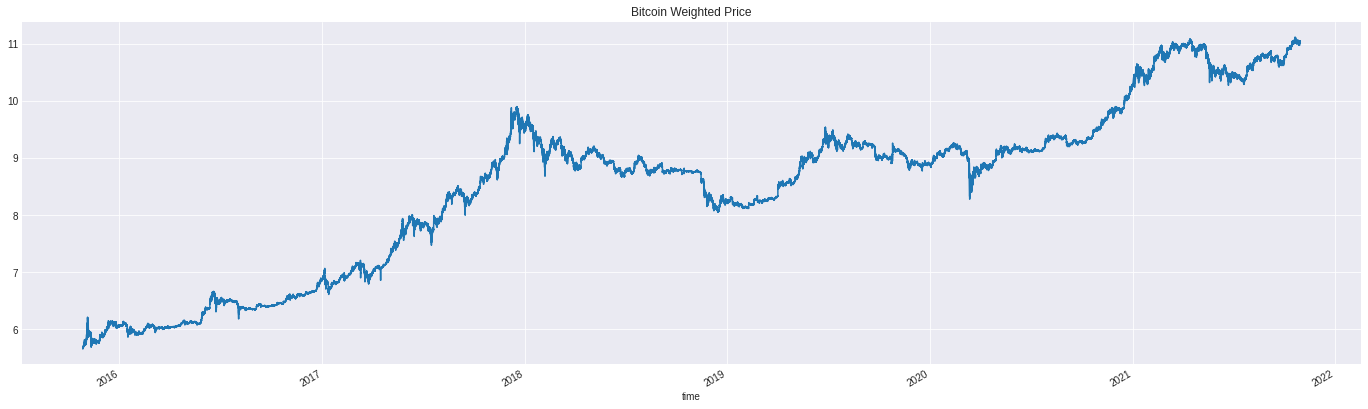

In [233]:
# btc_input_df_datetype.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")
btc_input_df_datetype.set_index("time").close_log.plot(figsize=(24,7), title="Bitcoin Weighted Price")

In [234]:
btc_input_df_datetype['date'] = pd.to_datetime(btc_input_df_datetype['time'],unit='s').dt.date

display(btc_input_df_datetype.head())

group = btc_input_df_datetype.groupby('date')

btc_closing_price_groupby_date = group['close_log'].mean()

display(btc_closing_price_groupby_date.head(10))

,time,low,high,open,close,volume,close_log,date
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079,11.033598,2021-10-30
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357,11.032997,2021-10-30
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848,11.033326,2021-10-30
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070,11.032490,2021-10-30
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128,11.032989,2021-10-30


date
2015-10-27    5.679741
2015-10-28    5.710364
2015-10-29    5.738202
2015-10-30    5.788838
2015-10-31    5.780111
2015-11-01    5.766747
2015-11-02    5.826106
2015-11-03    5.957086
2015-11-04    6.107486
2015-11-05    5.991228
Name: close_log, dtype: float64

In [237]:
btc = pd.DataFrame()
btc['close_log'] =  group['close_log'].mean()
# btc['diff1_log'] = btc['close_log'].diff(1)
# btc['diff7_log'] = btc['close_log'].diff(7)
# btc['diff30_log'] = btc['close_log'].diff(30)
# btc['high'] =  group['high'].mean()
# btc['low'] =  group['low'].mean()
btc['close'] =  group['close'].mean()
# btc['diff1'] = btc['close'].diff(1)
# btc['diff7'] = btc['close'].diff(7)
btc['diff30'] = btc['close'].diff(30)
# btc['diff60'] = btc['close'].diff(60)
# btc['diff90'] = btc['close'].diff(90)
# btc['reverse_diff'] = btc['close'].shift(1) + btc['diff']


btc['mom10'] = ta.mom(btc['close'],length=10)
# btc['mom30'] = ta.mom(btc['close'],length=30)
# btc['mom60'] = ta.mom(btc['close'],length=60)
# btc['mom90'] = ta.mom(btc['close'],length=90)

# btc['atr10'] = ta.atr(btc.high, btc.low, btc.close, length=10)
# btc['atr30'] = ta.atr(btc.high, btc.low, btc.close, length=30)
# btc['atr60'] = ta.atr(btc.high, btc.low, btc.close, length=60)
# btc['atr90'] = ta.atr(btc.high, btc.low, btc.close, length=90)

# btc['rsi14'] = ta.rsi(btc['close'],length=14)
# btc['rsi30'] = ta.rsi(btc['close'],length=30)
# btc['rsi60'] = ta.rsi(btc['close'],length=60)
# btc['rsi90'] = ta.rsi(btc['close'],length=90)


# stoch =ta.stoch(btc.high, btc.low, btc.close)
# stoch = stoch['STOCHd_14_3_3']-stoch['STOCHk_14_3_3']
# btc['stoch'] = stoch

# btc['adx'] = ta.adx(btc.high, btc.low, btc.close, length=30)['ADX_30']


btc['target_log'] = btc['close_log'].shift(-1)
# btc['target'] = btc['close'].shift(-1)
btc = btc.dropna()

In [238]:
btc.tail()

,close_log,close,diff30,mom10,target_log
date,,,,,
2021-10-25,11.044651,62611.015403,20017.460771,2725.561507,11.039727
2021-10-26,11.039727,62304.201403,19503.145444,1028.473299,10.993767
2021-10-27,10.993767,59508.951285,15986.450388,-1337.288333,11.006138
2021-10-28,11.006138,60252.358194,18317.494924,-1541.874306,11.028101
2021-10-29,11.028101,61584.211944,19759.308028,-1153.172500,11.035381


In [239]:
df_corr = btc.corr()
df_corr

,close_log,close,diff30,mom10,target_log
close_log,1.000000,0.791186,0.240545,0.153894,0.999733
close,0.791186,1.000000,0.360324,0.235202,0.790985
diff30,0.240545,0.360324,1.000000,0.597927,0.241470
mom10,0.153894,0.235202,0.597927,1.000000,0.155367
target_log,0.999733,0.790985,0.241470,0.155367,1.000000


In [240]:
with open('./drive/MyDrive/btc.moh','wb') as f :
    pickle.dump(btc,f)

# Load data

In [249]:
from google.colab import drive
drive.mount('/content/drive')
with open('./drive/MyDrive/btc.moh','rb') as f :
    btc = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [242]:
btc.head(2)

,close_log,close,diff30,mom10,target_log
date,,,,,
2015-11-26,5.837801,343.137357,50.249874,19.125267,5.875546
2015-11-27,5.875546,356.238255,54.246421,20.416975,5.872915


In [243]:
btc.columns 

Index(['close_log', 'close', 'diff30', 'mom10', 'target_log'], dtype='object')

In [250]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# StandardScaler
scaler = StandardScaler()

# scaler_diff1_log = StandardScaler()
# btc.diff1_log = scaler_diff1_log.fit_transform(btc.diff1_log.values.reshape(-1,1))

# scaler_diff7_log = StandardScaler()
# btc.diff7_log = scaler_diff7_log.fit_transform(btc.diff7_log.values.reshape(-1,1))

# scaler_diff30_log = StandardScaler()
# btc.diff30_log = scaler_diff30_log.fit_transform(btc.diff30_log.values.reshape(-1,1))

# scaler_diff1 = StandardScaler()
# btc.diff1 = scaler_diff1.fit_transform(btc.diff1.values.reshape(-1,1))

# scaler_diff7 = StandardScaler()
# btc.diff7 = scaler_diff7.fit_transform(btc.diff7.values.reshape(-1,1))

# scaler_high = StandardScaler()
# btc.high = scaler_high.fit_transform(btc.high.values.reshape(-1,1))

# scaler_low = StandardScaler()
# btc.low = scaler_low.fit_transform(btc.low.values.reshape(-1,1))

scaler_diff30 = StandardScaler()
btc.diff60 = scaler_diff30.fit_transform(btc.diff30.values.reshape(-1,1))

# scaler_diff60 = StandardScaler()
# btc.diff60 = scaler_diff60.fit_transform(btc.diff60.values.reshape(-1,1))

# scaler_diff90 = StandardScaler()
# btc.diff90 = scaler_diff90.fit_transform(btc.diff90.values.reshape(-1,1))

# scaler_rsi = StandardScaler()
# btc.rsi = scaler_rsi.fit_transform(btc.rsi.values.reshape(-1,1))

scaler_mom10 = StandardScaler()
btc.mom10 = scaler_mom10.fit_transform(btc.mom10.values.reshape(-1,1))

# scaler_mom30 = StandardScaler()
# btc.mom30 = scaler_mom30.fit_transform(btc.mom30.values.reshape(-1,1))

# scaler_mom60 = StandardScaler()
# btc.mom60 = scaler_mom60.fit_transform(btc.mom60.values.reshape(-1,1))

# scaler_mom90 = StandardScaler()
# btc.mom90 = scaler_mom90.fit_transform(btc.mom90.values.reshape(-1,1))

# scaler_atr10 = StandardScaler()
# btc.atr10 = scaler_atr10.fit_transform(btc.atr10.values.reshape(-1,1))

# scaler_atr30 = StandardScaler()
# btc.atr30 = scaler_atr30.fit_transform(btc.atr30.values.reshape(-1,1))

# scaler_atr60 = StandardScaler()
# btc.atr60 = scaler_atr60.fit_transform(btc.atr60.values.reshape(-1,1))

# scaler_atr90 = StandardScaler()
# btc.atr90 = scaler_atr90.fit_transform(btc.atr90.values.reshape(-1,1))

# scaler_t = StandardScaler()
# btc.close = scaler_t.fit_transform(btc.close.values.reshape(-1,1))
# btc.target = scaler_t.transform(btc.target.values.reshape(-1,1))

scaler_tlog = StandardScaler()
btc.close_log = scaler_tlog.fit_transform(btc.close_log.values.reshape(-1,1))
btc.target_log = scaler_tlog.transform(btc.target_log.values.reshape(-1,1))


In [251]:
btc.head(2)

,close_log,close,diff30,mom10,target_log
date,,,,,
2015-11-26,-1.920075,343.137357,50.249874,-0.106413,-1.893287
2015-11-27,-1.893287,356.238255,54.246421,-0.105895,-1.895154


### plot

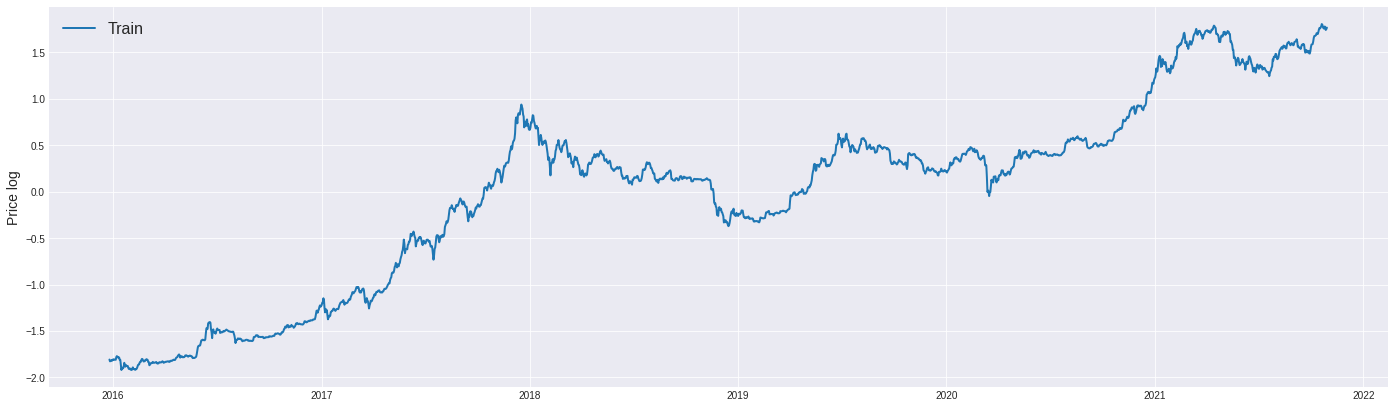

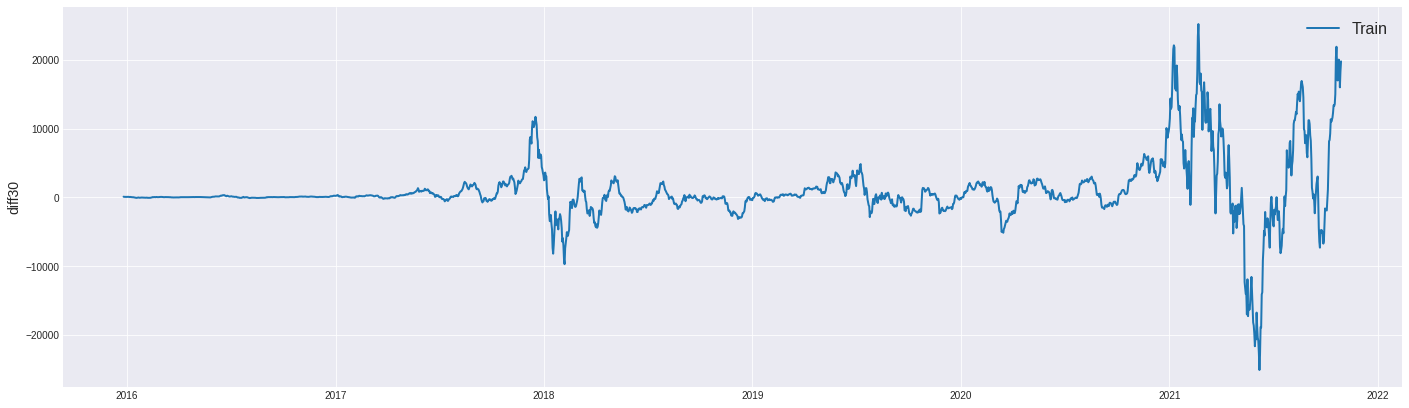

In [215]:
chosen_col = 'Close'

fig, ax = plt.subplots(1, figsize=(24, 7))
ax.plot(btc['close_log'], label='Train', linewidth=2)
ax.set_ylabel('Price log', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

fig, ax = plt.subplots(1, figsize=(24, 7))
ax.plot(btc['diff30'], label='Train', linewidth=2)
ax.set_ylabel('diff30', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

# fig, ax = plt.subplots(1, figsize=(24, 7))
# ax.plot(btc['diff60'], label='Train', linewidth=2)
# ax.set_ylabel('diff60', fontsize=14)
# ax.set_title('', fontsize=16)
# ax.legend(loc='best', fontsize=16)

# fig, ax = plt.subplots(1, figsize=(24, 7))
# ax.plot(btc['diff90'], label='Train', linewidth=2)
# ax.set_ylabel('diff90', fontsize=14)
# ax.set_title('', fontsize=16)
# ax.legend(loc='best', fontsize=16)



# creat data lstm

In [252]:
look_back_ = 5
prediction_days = 30
future_ = 30

look_b = btc[:][:len(btc)-(future_)]

df_train_= btc[:][:len(btc)-(prediction_days+future_)]#values.reshape(-1,1)

df_test_= btc[:][len(btc)-(prediction_days+future_+look_back_-1):len(btc)-future_]#.values.reshape(-1,1)

future_ = btc[:][len(btc)-(future_+look_back_-1):]


In [253]:
df_train_.columns

Index(['close_log', 'close', 'diff30', 'mom10', 'target_log'], dtype='object')

In [254]:
col = ['close_log', 'diff30', 'mom10', 'target_log']
df_train = df_train_[:][col]
df_test = df_test_[:][col]
future = future_[:][col]
df_test.head(2)

,close_log,diff30,mom10,target_log
date,,,,
2021-08-27,1.582802,7866.876215,0.597386,1.599881
2021-08-28,1.599881,9037.006542,1.391593,1.596503


In [255]:
# many to one

from collections import deque
def dataset_generator_lstm(dataset, look_back=look_back_):
  sequential_data = [] 
  prev_days = deque(maxlen=look_back)
  for i in dataset.values:
    prev_days.append([n for n in i[:-1]])
    if len(prev_days) == look_back:  
      sequential_data.append([np.array(prev_days), i[-1]])
  dataX=[]
  dataY=[]
  for seq, target in sequential_data: 
    dataX.append(seq) 
    dataY.append(target) 
  return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(df_train)

testX, testY = dataset_generator_lstm(df_test)

futureX, futureY = dataset_generator_lstm(future)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)
print("futureX: ", futureX.shape)
print("futureY", futureY.shape)

trainX:  (2101, 5, 3)
trainY:  (2101,)
testX:  (30, 5, 3)
testY (30,)
futureX:  (30, 5, 3)
futureY (30,)


# train

In [256]:
regressor = Sequential()

regressor.add(LSTM(units = 512, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 265, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 128, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = look_back_, activation = 'relu'))

regressor.add(Dense(units = 1))

regressor.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 5, 512)            1056768   
                                                                 
 dropout_27 (Dropout)        (None, 5, 512)            0         
                                                                 
 lstm_28 (LSTM)              (None, 5, 265)            824680    
                                                                 
 dropout_28 (Dropout)        (None, 5, 265)            0         
                                                                 
 lstm_29 (LSTM)              (None, 128)               201728    
                                                                 
 dropout_29 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 5)                

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]


# history = regressor.fit(trainX[(len(trainY)-370):], trainY[(len(trainY)-370):], batch_size = 128, epochs = 300, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)
history = regressor.fit(trainX, trainY, batch_size = 128, epochs = 300, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [222]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

# test test

In [ ]:
plt.figure(figsize=(16,7))

# log
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
predicted_btc_price_test_data = scaler_tlog.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
test_actual = scaler_tlog.inverse_transform(testY.reshape(-1, 1))

plt.plot(np.exp(predicted_btc_price_test_data), 'r', marker='.', label='Predicted Test')
plt.plot(np.exp(test_actual), marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
# predicted_btc_price_test_data = scaler_t.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
# test_actual = scaler_t.inverse_transform(testY.reshape(-1, 1))

# plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
# plt.plot(test_actual, marker='.', label='Actual Test')


plt.legend()
plt.show()

#test train

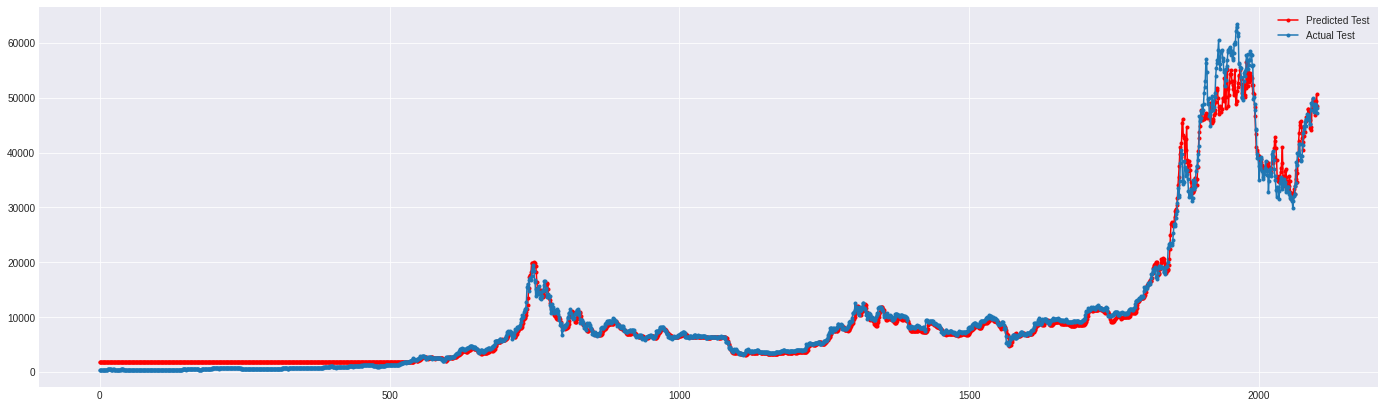

In [32]:
plt.figure(figsize=(24,7))

# log
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
predicted_btc_price_train_data = scaler_tlog.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))
train_actual = scaler_tlog.inverse_transform(trainY.reshape(-1, 1))

plt.plot(np.exp(predicted_btc_price_train_data), 'r', marker='.', label='Predicted Test')
plt.plot(np.exp(train_actual), marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
# predicted_btc_price_train_data = scaler_t.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))
# train_actual = scaler_t.inverse_transform(trainY.reshape(-1, 1))

# plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Test')
# plt.plot(train_actual, marker='.', label='Actual Test')


plt.legend()
plt.show()

# score

## log

In [223]:
rmse_lstm_test = math.sqrt(mean_squared_error(np.exp(test_actual), np.exp(predicted_btc_price_test_data)))

print('Test RMSE: %.3f' % rmse_lstm_test)


Test RMSE: 6276.525


In [224]:
rmse_lstm_train = math.sqrt(mean_squared_error(np.exp(train_actual), np.exp(predicted_btc_price_train_data)))

print('Test RMSE: %.3f' % rmse_lstm_train)


Test RMSE: 2010.802


## manoal

In [152]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)


Test RMSE: 2951.213


In [153]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Test RMSE: %.3f' % rmse_lstm_train)


Test RMSE: 1503.741


# future

###### genertor

In [35]:
look_b.tail(7)

,close_log,diff1_log,diff7_log,diff30_log,close,diff1,diff7,diff30,rsi,mom,target_log,target
date,,,,,,,,,,,,
2021-09-23,1.526519,1.010844,-0.955004,-0.735054,2.186577,2.306546,-1.949076,-1.264034,-0.825745,-0.395953,1.510573,2.121737
2021-09-24,1.510573,-0.763371,-1.106411,-0.773862,2.121737,-1.526758,-2.264716,-1.336361,-0.994597,-1.283523,1.501905,2.085508
2021-09-25,1.501905,-0.448938,-1.354658,-0.744568,2.085508,-0.872251,-2.847778,-1.251775,-1.085844,-2.115735,1.505278,2.099442
2021-09-26,1.505278,0.071371,-1.208299,-0.759213,2.099442,0.275288,-2.500280,-1.293334,-1.027562,-2.157325,1.517183,2.147888
2021-09-27,1.517183,0.440074,-0.398834,-0.789938,2.147888,1.064788,-0.632671,-1.391859,-0.824609,-1.740665,1.490817,2.041276
2021-09-28,1.490817,-1.213665,-0.276198,-0.926464,2.041276,-2.482334,-0.342978,-1.698312,-1.120085,-2.639959,1.488943,2.033892
2021-09-29,1.488943,-0.155329,-0.330620,-0.886788,2.033892,-0.212383,-0.458628,-1.591450,-1.139407,-2.481561,1.512942,2.130458


In [168]:
# def rsi():
#   return scaler_rsi.transform(np.array(ta.rsi(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=14))[-1].reshape(-1,1)).reshape(-1,1)

def mom30():
  return scaler_mom30.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=30))[-1].reshape(-1,1))).reshape(-1,1)

def mom60():
  return scaler_mom60.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=60))[-1].reshape(-1,1))).reshape(-1,1)

def mom90():
  return scaler_mom90.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=90))[-1].reshape(-1,1))).reshape(-1,1)

  
# def diff1_log(): # target log
#   d_old = scaler_tlog.inverse_transform(np.array(c_log)[-1].reshape(-1,1))
#   d_new = scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)).reshape(-1,1)
#   d = scaler_diff1_log.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

# def diff7_log(): # target log
#   d_old = scaler_tlog.inverse_transform(np.array(c_log)[-7].reshape(-1,1))
#   d_new = scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)).reshape(-1,1)
#   d = scaler_diff7_log.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

# def diff30_log(): # target log
#   d_old = scaler_tlog.inverse_transform(np.array(c_log)[-30].reshape(-1,1))
#   d_new = scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)).reshape(-1,1)
#   d = scaler_diff30_log.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

# def diff1(): # target log
#   d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-1].reshape(-1,1)))
#   d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
#   d = scaler_diff1.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

# def diff7(): # target log
#   d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-8].reshape(-1,1)))
#   d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
#   d = scaler_diff7.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

def diff30(): # target log
  d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-31].reshape(-1,1)))
  d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
  d = scaler_diff30.transform(np.array(d_new - d_old).reshape(-1,1))
  return d

  def diff60(): # target log
  d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-61].reshape(-1,1)))
  d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
  d = scaler_diff30.transform(np.array(d_new - d_old).reshape(-1,1))
  return d

  def diff90(): # target log
  d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-91].reshape(-1,1)))
  d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
  d = scaler_diff30.transform(np.array(d_new - d_old).reshape(-1,1))
  return d


IndentationError: ignored

###### many to one

In [44]:
from collections import deque

maxlen = 60
c_log = deque(maxlen=maxlen)

for i in range(-maxlen,0,1):
  # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
  c_log.append(look_b['close_log'].values[i])

  
SEQ_LEN=len(testX[-1])
prev_days = deque(maxlen=SEQ_LEN)

for i in range(-len(testX[-1]),0,1):
  # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
  prev_days.append(testX[-1][i])

In [ ]:
# ['close_log', 'diff30', 'mom', 'target_log'] len 5 
col

In [45]:
y_p_ = []
future_len = 30
for i in range(future_len):
  x__ = np.array(prev_days).reshape(-1,len(np.array(prev_days)[-1])).astype(np.float32)

  per = model_from_saved_checkpoint.predict(np.array([x__,x__]))[0].reshape(-1,1)

  # Rsi = rsi()
  Mom30 = mom30()
  Mom60 = mom60()
  Mom90 = mom90()
  # Diff1_log = diff1_log()
  # Diff7_log = diff7_log()
  # Diff30_log = diff30_log()
  # Diff1 = diff1()
  # Diff7 = diff7()
  Diff30 = diff30()
  Diff60 = diff60()
  Diff90 = diff90()

  prev_days.append([per.reshape(-1,1), Diff30, Diff60, Diff90, Mom30, Mom60, Mom90]) # , Diff1_log, Diff7_log, Diff30_log, Diff1, Diff7, Rsi,
  c_log.append(np.array(per).reshape(-1,1))
  y_p_.append(per.reshape(-1,1))


In [46]:
# log
y_p_ = scaler_tlog.inverse_transform(np.array(y_p_).reshape(-1, 1))
# manoal
# y_p_ = scaler_t.inverse_transform(np.array(y_p_).reshape(-1, 1))

###### plot future

In [47]:
future_actual = scaler_tlog.inverse_transform(futureY.reshape(-1, 1))
actual = np.concatenate((train_actual,test_actual,future_actual))
predicted_btc_price = np.concatenate((predicted_btc_price_train_data, predicted_btc_price_test_data, np.array(y_p_).reshape(-1,1)), axis=0)

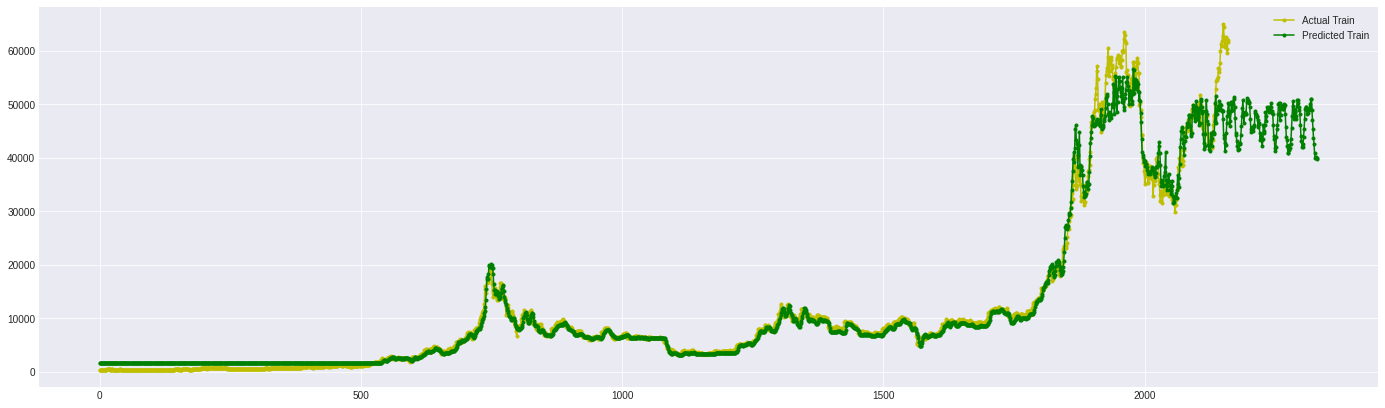

In [48]:
plt.figure(figsize=(24,7))

# log
plt.plot(np.exp(actual),'y', marker='.', label='Actual Train')
plt.plot(np.exp(predicted_btc_price), 'g', marker='.', label='Predicted Train')
# manoal
# plt.plot(actual,'y', marker='.', label='Actual Train')
# plt.plot(predicted_btc_price, 'g', marker='.', label='Predicted Train')


plt.legend()
plt.show()